In [1]:
import numpy as np 
import pandas as pd
import warnings
import seaborn as sns
%matplotlib inline
from IPython.display import Image
from sklearn.tree import export_graphviz
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn import metrics

In [3]:
df = pd.read_csv('dataset/marketing_campaign.csv', delimiter=';')
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [4]:
df.shape

(2240, 29)

In [5]:
df.isnull().sum().any()

True

In [6]:
df.drop(['Z_CostContact', 'Z_Revenue'], axis=1, inplace=True)
df.Dt_Customer = pd.to_datetime(df['Dt_Customer'])
df['Dt_Customer_Month'] = df['Dt_Customer'].dt.to_period("M")
df['acc_age'] = (pd.to_datetime("2014-12").year - df['Dt_Customer_Month'].dt.year)*12 + (pd.to_datetime("2014-12").month - df['Dt_Customer_Month'].dt.month)
df.drop(['Dt_Customer_Month', 'Dt_Customer'], axis=1, inplace=True)
df['Age'] = 2014 - df["Year_Birth"]
df.drop(['Year_Birth'], axis=1, inplace=True)
df['Income'] = df['Income'].fillna(df.Income.mean(), axis = 0)
df.head()

,ID,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,acc_age,Age
0,5524,Graduation,Single,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,27,57
1,2174,Graduation,Single,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,9,60
2,4141,Graduation,Together,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,16,49
3,6182,Graduation,Together,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,10,30
4,5324,PhD,Married,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,11,33


In [7]:
df.describe()

,ID,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,acc_age,Age
count,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,5592.159821,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,27.062946,44.021875,2.325000,4.084821,2.662054,5.790179,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.009375,0.149107,17.195089,45.194196
std,3246.662198,25037.797168,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,41.280498,52.167439,1.932238,2.778714,2.923101,3.250958,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.096391,0.356274,6.639904,11.984069
min,0.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,18.000000
25%,2828.250000,35538.750000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,37.000000
50%,5458.500000,51741.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,44.000000
75%,8427.750000,68289.750000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.000000,55.000000
max,11191.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,29.000000,121.000000


In [8]:
one_hot = OneHotEncoder(handle_unknown='ignore')
one_hot_edu_df = pd.DataFrame(one_hot.fit_transform(df[['Education']]).toarray())
df = df.join(one_hot_edu_df)

In [9]:
df.Marital_Status.unique()

array(['Single', 'Together', 'Married', 'Divorced', 'Widow', 'Alone',
       'Absurd', 'YOLO'], dtype=object)

In [10]:
ms_label = {value: key for key, value in enumerate(df.Marital_Status.unique())}
df.Marital_Status = df.Marital_Status.map(ms_label)
edu_label = {value: key for key, value in enumerate(df.Education.unique())}
df.Education = df.Education.map(edu_label)

In [11]:
df["total_Mnt"] = df["MntWines"] + df["MntFruits"] + df["MntMeatProducts"]+ df['MntFishProducts'] + df["MntSweetProducts"] + df["MntGoldProds"]
df['MntWines_pct'] = df['MntWines'] / df['total_Mnt']
df['MntFruits_pct'] = df["MntFruits"] / df['total_Mnt']
df["MntMeatProducts_pct"] = df["MntMeatProducts"] / df['total_Mnt']
df["MntFishProducts_pct"] = df["MntFishProducts"] / df['total_Mnt']
df["MntSweetProducts_pct"] = df["MntSweetProducts"] / df['total_Mnt']
df["MntGoldProds_pct"] = df["MntGoldProds"] / df['total_Mnt']

In [12]:
df.head()

,ID,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,acc_age,Age,0,1,2,3,4,total_Mnt,MntWines_pct,MntFruits_pct,MntMeatProducts_pct,MntFishProducts_pct,MntSweetProducts_pct,MntGoldProds_pct
0,5524,0,0,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,27,57,0.0,0.0,1.0,0.0,0.0,1617,0.392703,0.054422,0.337662,0.106370,0.054422,0.054422
1,2174,0,0,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,9,60,0.0,0.0,1.0,0.0,0.0,27,0.407407,0.037037,0.222222,0.074074,0.037037,0.222222
2,4141,0,1,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,16,49,0.0,0.0,1.0,0.0,0.0,776,0.548969,0.063144,0.163660,0.143041,0.027062,0.054124
3,6182,0,1,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,10,30,0.0,0.0,1.0,0.0,0.0,53,0.207547,0.075472,0.377358,0.188679,0.056604,0.094340
4,5324,1,2,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,11,33,0.0,0.0,0.0,0.0,1.0,422,0.409953,0.101896,0.279621,0.109005,0.063981,0.035545


In [13]:
X = df.drop(['Response'], axis=1, inplace=False)
y = df['Response']
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.4, random_state = 123)

In [14]:
rfc = RandomForestClassifier(n_estimators=30,random_state=1)
max_depth_range = range(1,16)
param_grid = dict(max_depth=max_depth_range)
grid = GridSearchCV(rfc,param_grid,cv = 10,scoring = 'accuracy')
grid.fit(X_train, y_train)

{'mean_fit_time': array([0.12764859, 0.18348267, 0.15487468, 0.2852711 , 0.16955502,
        0.23171537, 0.18900514, 0.18673263, 0.22984016, 0.19340119,
        0.23409848, 0.21537378, 0.21935484, 0.24117107, 0.24686272]),
 'std_fit_time': array([0.04102643, 0.1091287 , 0.05373394, 0.11673365, 0.01990118,
        0.03753596, 0.01878157, 0.01211648, 0.08205044, 0.00956692,
        0.02485887, 0.01808078, 0.03034595, 0.03615711, 0.04269697]),
 'mean_score_time': array([0.01329165, 0.02025387, 0.01215749, 0.02972291, 0.01213312,
        0.01093886, 0.01289136, 0.0103615 , 0.01003921, 0.00986626,
        0.01307302, 0.01166794, 0.00988247, 0.01449788, 0.01768281]),
 'std_score_time': array([0.00914362, 0.01857884, 0.00555204, 0.02902944, 0.00698316,
        0.00662096, 0.00590945, 0.00730055, 0.0082003 , 0.00743296,
        0.00400665, 0.00631229, 0.00661491, 0.00631449, 0.00994349]),
 'param_max_depth': masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
              m

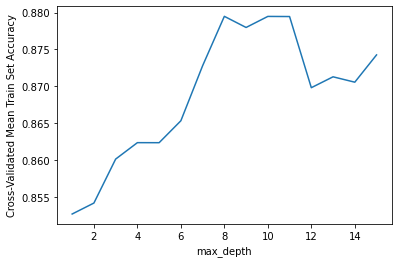

In [15]:
grid_mean_scores = grid.cv_results_["mean_test_score"]
grid_test_mean_scores = metrics
# plot the results
sns.mpl.pyplot.plot(max_depth_range, grid_mean_scores)
sns.mpl.pyplot.xlabel('max_depth')
sns.mpl.pyplot.ylabel('Cross-Validated Mean Train Set Accuracy');

In [16]:
best_rfc = RandomForestClassifier(n_estimators=50,random_state=1,max_depth = 12)
best_rfc.fit(X_train, y_train)
rfc_pred = best_rfc.predict(X_test)
accuracy_train = metrics.accuracy_score(y_train, best_rfc.predict(X_train))
accuracy_test = metrics.accuracy_score(y_test, rfc_pred)
print("Accuracy of Random Forest train is: ", accuracy_train)
print("Accuracy of Random Forest test is: ", accuracy_test)

Accuracy of Random Forest train is:  0.9903273809523809
Accuracy of Random Forest test is:  0.8671875


In [17]:
y_test_pred_rcf = best_rfc.predict(X_test)

In [18]:
print("Classification Report:\n", metrics.classification_report(y_test,y_test_pred_rcf))

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       760
           1       0.66      0.26      0.37       136

    accuracy                           0.87       896
   macro avg       0.77      0.62      0.65       896
weighted avg       0.85      0.87      0.84       896



In [19]:
pred_probs_rcf =  best_rfc.predict_proba(X_test)
pred_probs_rcf

array([[0.90585131, 0.09414869],
       [0.98361685, 0.01638315],
       [0.8715022 , 0.1284978 ],
       ...,
       [0.99386854, 0.00613146],
       [0.86      , 0.14      ],
       [0.94502721, 0.05497279]])

In [20]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_probs_rcf[:,1])

Text(0, 0.5, 'True Positive Rate (Sensitivity)')

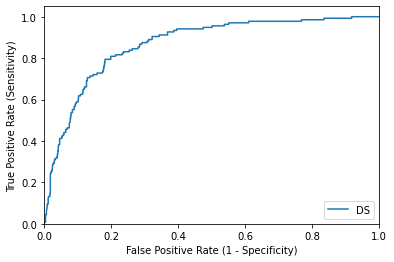

In [21]:
sns.mpl.pyplot.plot(fpr, tpr,label="DS")
sns.mpl.pyplot.xlim([0, 1])
sns.mpl.pyplot.ylim([0, 1.05])
sns.mpl.pyplot.legend(loc="lower right")
sns.mpl.pyplot.xlabel('False Positive Rate (1 - Specificity)')
sns.mpl.pyplot.ylabel('True Positive Rate (Sensitivity)')

In [22]:
print("Test AUC: ",metrics.roc_auc_score(y_test, best_rfc.predict(X_test)))

Test AUC:  0.6168343653250774
